In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

In [2]:
# rotation matrix
Rx = lambda theta: np.array([[1, 0, 0],
                             [0, np.cos(theta), -np.sin(theta)],
                             [0, np.sin(theta), np.cos(theta)]])
Ry = lambda theta: np.array([[np.cos(theta), 0, np.sin(theta)],
                             [0, 1, 0],
                             [-np.sin(theta), 0, np.cos(theta)]])
Rz = lambda theta: np.array([[np.cos(theta), -np.sin(theta), 0], 
                             [np.sin(theta), np.cos(theta), 0], 
                             [0, 0, 1]])

In [3]:
# return data of an arrow object
def arrow(start, end, color='black', name=None):
    start = start.flatten()
    end = end.flatten()
    head_scale = 0.3 # adjusts the cone size scaling 

    body = go.Scatter3d(x = [start[0], end[0]],
                        y = [start[1], end[1]],
                        z = [start[2], end[2]], 
                        mode = "lines",
                        line = dict(color=color), 
                        showlegend = False)
    
    head = go.Cone(x = [end[0]], y = [end[1]], z = [end[2]],
                   u = [end[0]-start[0]], v = [end[1]-start[1]], w = [end[2]-start[2]],
                   sizemode = "scaled",
                   sizeref = head_scale,
                   colorscale = [[0, color], [1, color]],
                   showscale=False,
                   showlegend=False)
    
    dist = 0.4
    text = go.Scatter3d(x = [-dist * start[0] + (1 + dist) * end[0]],
                        y = [-dist * start[1] + (1 + dist) * end[1]],
                        z = [-dist * start[2] + (1 + dist) * end[2]],
                        mode = "text",
                        text = [name],
                        textposition = 'middle center',
                        showlegend = False,
                        textfont = dict(color=color))
    result = [body, head, text]
    return result 

# return data of a frame object
def frame(pose=np.eye(3), center=np.zeros(3), color='black'):
    # original center and pose 
    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])
    o = np.zeros(3)

    # transformed center and pose  
    x_axis = pose @ x_axis
    y_axis = pose @ y_axis
    z_axis = pose @ z_axis
    o = center

    fig_data = []
    fig_data.extend(arrow(o, o + x_axis, color=color, name='x'))
    fig_data.extend(arrow(o, o + y_axis, color=color, name='y'))
    fig_data.extend(arrow(o, o + z_axis, color=color, name='z'))
    return fig_data

def line(start, end, color='black'):
    fig_data = go.Scatter3d(x = [start[0], end[0]], 
                            y = [start[1], end[1]], 
                            z = [start[2], end[2]], 
                            mode = "lines", line = dict(color=color), opacity=0.3, showlegend = False)
    return [fig_data]

# include image plane and the 4 lines from focal point to the 4 corners of the image plane
def image_plane(pose, center, focal_len, img_width, img_height, color='black'):
    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])
    x_axis = pose @ x_axis 
    y_axis = pose @ y_axis
    z_axis = pose @ z_axis
    o = center # center of the camera coordinate frame
    img_center = o + z_axis * focal_len # center of the image plane 

    # 4 corners of the image plane 
    corner1 = img_center - (img_width / 2) * x_axis - (img_height / 2) * y_axis
    corner2 = img_center + (img_width / 2) * x_axis - (img_height / 2) * y_axis
    corner3 = img_center + (img_width / 2) * x_axis + (img_height / 2) * y_axis
    corner4 = img_center - (img_width / 2) * x_axis + (img_height / 2) * y_axis
    corners = np.vstack([corner1, corner2, corner3, corner4])
    
    data = [go.Mesh3d(x=corners[:, 0], y=corners[:, 1], z=corners[:, 2], 
                      i=[0, 0],  # vertices of first triangle
                      j=[1, 2],  # vertices of second triangle
                      k=[2, 3],  # vertices of third triangle
                      opacity=.3, color=color)]
    data.extend(line(o, corner1, color=color))
    data.extend(line(o, corner2, color=color))
    data.extend(line(o, corner3, color=color))
    data.extend(line(o, corner4, color=color))

    return data

drange = 4 # set the plot size
graph_center = np.array([2, 0, 1])
def plot_all(figs, world=False, pltrange=[[-drange+graph_center[0], drange+graph_center[0]], 
                                           [-drange+graph_center[1], drange+graph_center[1]],
                                           [-drange+graph_center[2], drange+graph_center[2]]]):
    if world == True:
        fig_data = frame(color='gray')
        for fig in figs:
            fig_data.extend(fig.get_fig_data())
        FIG = go.Figure(data=fig_data)
        FIG.update_layout(
            scene = dict(
                xaxis = dict(nticks = 4, range = pltrange[0]),
                yaxis = dict(nticks = 4, range = pltrange[1]),
                zaxis = dict(nticks = 4, range = pltrange[2]),
                # set aspectratio to 1:1:1
                aspectratio = dict(x = 1, y = 1, z = 1)
            ), 
            width=500,
            height=500,
            margin=dict(l=10, r=10, t=10, b=10),
        )
    else:
        fig_data = []
        for fig in figs:
            fig_data.extend(fig.get_fig_data())
        FIG = go.Figure(data=fig_data)

    FIG.show()

In [4]:
class PointCloud():
    
    # data = [pts, "color"]
    def __init__(self):
        self.pts_data = []
        
    def add_data(self, data):
        # default color is black
        if data:
            if len(data) <= 1:
                data.append('black')
        self.pts_data.append(data) 
        
    def get_fig_data(self):
        fig_data = []
        if self.pts_data:
            for pts, color in self.pts_data:
                fig_data.append(go.Scatter3d(
                    x = pts[:, 0],
                    y = pts[:, 1],
                    z = pts[:, 2],
                    mode = 'markers',
                    marker = dict(size = 2, color = color, opacity=1),
                    showlegend = False))
        
        return fig_data
    
class Camera():

    def __init__(self, pose, center, name=None):
        self.pose = pose
        self.center = center
        self.focal_len = 1
        self.img_width = 4
        self.img_height = 2
        self.name = name

        # coordinate frame 
        self.fig_data = frame(self.pose, self.center)
        # image plane 
        self.fig_data.extend(image_plane(self.pose, self.center, self.focal_len, self.img_width, self.img_height))
        # add name 
        if self.name is not None:
            self.add_name()

        # data points in represented by different coordinate frames
        self.pts_data = None # pts_data = [[pts1, color1], [pts2, color2], ...]
        self.world_pts = None 
        self.camera_pts = None 
        self.image_pts = None 

        # store the color of the points
        self.pts_color = None

        # camera projection matrix
        self.P = np.array([[self.focal_len, 0, 0, 0], 
                           [0, self.focal_len, 0, 0],
                           [0, 0, 1, 0]])
        # camera calibration matrix
        self.K = np.array([[self.focal_len, 0, self.img_width/2],
                           [0, self.focal_len, self.img_height/2],
                           [0, 0, 1]])

    def get_fig_data(self):
        return self.fig_data

    def plot_camera(self):
        # plot coordinate frame 
        fig = go.Figure(data=self.fig_data)
        fig.show()

    def capture(self, pts):
        self.pts_data = pts.pts_data

        self.world_pts = np.vstack([d[0] for d in self.pts_data])
        self.pts_color = np.array([d[1] for d in self.pts_data for _ in range(d[0].shape[0])])

        # transform the data to the camera coordinate frame
        # remember the formula: X_camera = pose.T @ (X_world - center)
        camera_pts = (self.world_pts - self.center) @ self.pose
        self.camera_pts = camera_pts[camera_pts[:, -1] > self.focal_len] # remove points behind the camera
        
        # transform the data to the image coordinate frame
        #data_homo = np.hstack((self.camera_data, np.ones((data.shape[0], 1))))
        #self.image_data = data_homo @ self.P.T
        
        image_pts = self.camera_pts @ self.K.T 
        self.image_pts = image_pts / image_pts[:, -1][:, None]
        
    def show_image(self):
        # remove the point that is outside of the image plane 
        idx = (self.image_pts[:, 1] > 0) * (self.image_pts[:, 1] < self.img_height) * (self.image_pts[:, 0] < self.img_width) * (self.image_pts[:, 0] > 0)
        image_pts = self.image_pts[idx]
        camera_pts = self.camera_pts[idx]
        
        dist = np.linalg.norm(camera_pts - np.array([0, 0, self.focal_len]), axis = 1)
        scaling = 5 / (dist - self.focal_len + 0.6)
    
        plt.figure()
        plt.scatter(image_pts[:, 0], image_pts[:, 1], c=self.pts_color[idx], s=scaling)
        plt.xlim([0, self.img_width])
        plt.ylim([0, self.img_height])
        plt.gca().set_aspect('equal')
        plt.show()

    # add name for this camera
    def add_name(self):
        fig_data = go.Scatter3d(x = [self.center[0]], 
                                y = [self.center[1]], 
                                z = [self.center[2]],
                                text = [self.name],
                                mode = 'text', 
                                marker = dict(size = 2, color = 'black', opacity=1), 
                                showlegend = False)
        self.fig_data.append(fig_data)

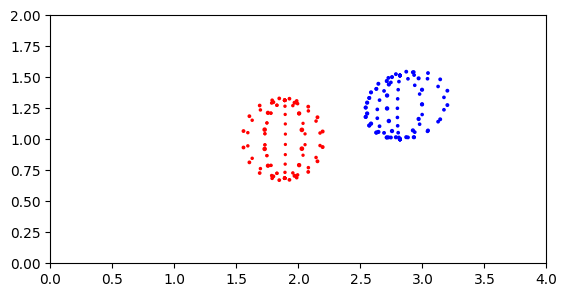

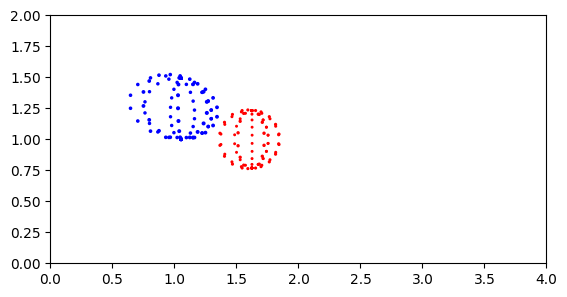

In [5]:
# example data 
px, py, pz = 4.5, 1, 1
data = np.array([[np.cos(theta)*np.sin(phi)+px, np.sin(theta)*np.sin(phi)+py, np.cos(phi)+pz] 
                 for theta in np.linspace(0, 2*np.pi, 10)
                 for phi in np.linspace(0, np.pi, 10)])

pts = PointCloud()
pts.add_data([data, 'red'])
pts.add_data([data*0.5, 'blue'])


camera1 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(np.pi/4), np.array([2, 3, 1]), "Cam1")
camera2 = Camera(Ry(np.pi/2)@Rz(-np.pi/2)@Ry(-np.pi/9), np.array([1, -2, 1]), "Cam2")


camera1.capture(pts)
camera2.capture(pts)

plot_all([camera1, camera2, pts], world=True)
camera1.show_image()
camera2.show_image()